## 21cmSense notes:
- Maybe remove for loop in `Observatory.grid_baselines` for coherent=True case (https://github.com/rasg-affiliates/21cmSense/blob/main/src/py21cmsense/observatory.py#L571)
- Maybe only keep positive bls and add in the mirrored ones only when needed, so don't concatenate here https://github.com/rasg-affiliates/21cmSense/blob/main/src/py21cmsense/observatory.py#L622
- Maybe allow for an `Observatory` to have multiple frequencies at once. This avoids a ton of for loops in user code.
- Maybe add `Observatory.A_eff` and `Observatory.Omega_beam`.

In [1]:
import numpy as np
from py21cmsense import Observatory, Observation, hera, GaussianBeam
from astropy.cosmology import Planck15
from py21cmsense.conversions import dk_du, f2z
import tqdm
import astropy.units as un
from astropy.cosmology.units import littleh

from tools21cm.radio_telescope_noise import get_uv_map, get_SKA_Low_layout
import matplotlib.pyplot as plt

In [2]:
def compare(tools_qt, tuesday_qt, qt_name="", vmin=None, vmax=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    if vmin is None:
        vmin = np.nanpercentile(tools_qt, 2.5)
    if vmax is None:
        vmax = np.nanpercentile(tools_qt, 97.5)
    axs[0].set_title(f"tuesday - {qt_name} at 150 MHz for SKA AA4")
    axs[0].imshow(np.flip(tuesday_qt.T), origin="lower", vmin = vmin, vmax = vmax)
    axs[1].set_title(f"Current tools21cm - {qt_name} at 150 MHz for SKA AA4")
    axs[1].imshow(tools_qt.T, origin="lower", vmin = vmin, vmax = vmax)
    plt.show()
    err = tools_qt.T - np.flip(tuesday_qt.T)
    vmin = np.nanpercentile(err, 2.5)
    vmax = np.nanpercentile(err, 97.5)
    fig, axs = plt.subplots(1,2, figsize=(12, 6))
    im = axs[0].imshow(err, vmin = vmin, vmax = vmax, origin="lower")
    fig.colorbar(im,  label = f"tools21cm  {qt_name} - 21cmSense {qt_name}", fraction=0.1,shrink=0.8)
    axs[1].hist(err.ravel(), bins = np.linspace(vmin,vmax,20))
    axs[1].set_xlabel(f"tools21cm {qt_name} - 21cmSense {qt_name}")
    plt.show()

In this notebook, we compare lightcone noise generation methods from `tools21cm` (master branch on 01/07/25, commit c0cc4d5) with `tuesday`.
We do this using the `AA4` SKA layout. We start by checking that the station layouts in both codes are the same:

# Compare SKA AA4 layouts

In [3]:
hours_tracking = 6.*un.hour
observatory = Observatory.from_ska("AA4")
freqs = [150.0 * un.MHz]

In [4]:
enu_coords = get_SKA_Low_layout("AA4", unit="enu")

AA4 contains 512 antennae.


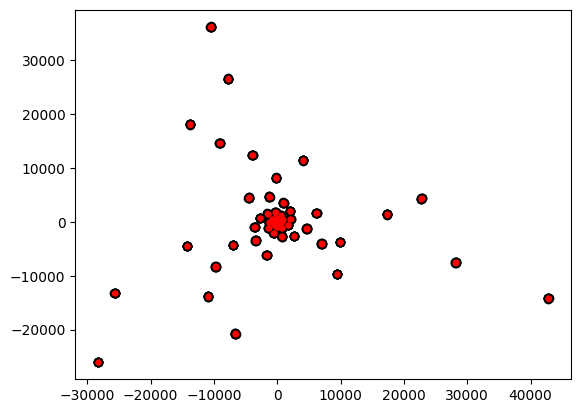

In [5]:
plt.scatter(enu_coords[:,0], enu_coords[:,1], color = "k")
plt.scatter(observatory.antpos[:,0], observatory.antpos[:,1], color = "r", marker = ".")
plt.show()

We confirm that both `tools21cm` and `21cmSense` are using the same SKA antenna layout.
Next calculate the uv coverage.
# Calculating uv coverage with `tuesday`

In [6]:
observatory = observatory.clone(beam=observatory.beam.clone(frequency=freqs[0]))
integration_time = 60*un.s
time_offsets = observatory.time_offsets_from_obs_int_time(integration_time, hours_tracking)

In [7]:
baseline_groups = observatory.get_redundant_baselines()
print(len(list(baseline_groups.values())))
baselines = observatory.baseline_coords_from_groups(baseline_groups)
print(baselines.shape)
weights = observatory.baseline_weights_from_groups(baseline_groups)
bl_max = np.sqrt(np.max(np.sum(baselines**2, axis=1)))

finding redundancies: 100%|██████████| 511/511 [00:01<00:00, 500.71ants/s]


261582
(261582, 3)


In [40]:
def grid_baselines(uvws, freq, boxlength: un.Quantity, lc_shape, weights):
    # our code is commented out. It yields slightly smaller ugrid_edges.max() than tools.
    # this is only for comparison.
    dx = float(boxlength.value) / float(lc_shape[0])
    ugrid_edges = np.fft.fftshift(np.fft.fftfreq(lc_shape[0], d=dx)) * 2*np.pi / Planck15.h * littleh/un.Mpc# h/Mpc
    # Add missing right edge
    ugrid_edges = np.append(ugrid_edges, ugrid_edges[-1:] + ugrid_edges[-1:] - ugrid_edges[-2], axis=0)
    # convert k to u
    ugrid_edges /= dk_du(f2z(freq))
#     box_size_radians = 0.031837658868332626# same as tools21cm, this is boxlength.value / comoving_distance
#     ugrid_edges = np.fft.fftshift(np.fft.fftfreq(lc_shape[0], d=box_size_radians/lc_shape[0]))
#     ugrid_edges = np.concatenate((ugrid_edges, np.expand_dims(ugrid_edges[-1] + ugrid_edges[-1] - ugrid_edges[-2], axis = 0)), axis = 0)
    print(ugrid_edges.shape, ugrid_edges.min(), ugrid_edges.max())

    dim = len(ugrid_edges) - 1

    weights = np.repeat(weights, uvws.shape[1])
    uvws = uvws.reshape((uvws.shape[0]*uvws.shape[1], -1))
    uvsum = np.histogram2d(uvws[:,0], uvws[:,1], bins=ugrid_edges, weights=weights)[0]
    # add mirrored baselines to uv grid
    uvsum += np.flip(uvsum)
    # but they're not independent measurements
    uvsum /= 2.
    return uvsum

In [41]:
# this step runs out of mem on my laptop / trantor w int time = 10 
proj_bls = observatory.projected_baselines(baselines=baselines, #21cmsense caches them 
                                           time_offset = time_offsets, ) #(Nbls, N time_offsets, 3)

In [42]:
proj_bls.shape, weights.shape

((261582, 361, 3), (261582,))

In [43]:
num_bl_groups = proj_bls.shape[0]
print(proj_bls.shape)

(261582, 361, 3)


In [44]:
lc_shape = np.array([200,200,1945])
boxlength = 300. *un.Mpc

In [48]:
proj_bls.shape

(261582, 361, 3)

In [45]:
uv_coverage = np.zeros((lc_shape[0],lc_shape[0],len(freqs)))#Nu, Nv, Nfreqs
for i, freq in enumerate(freqs): #number of lc z slices / chunks (e.g. in Matteo's paper) -> big
    # uv coverage integrated over one field
    uv_coverage[...,i] += grid_baselines(proj_bls[::2]*freq/freqs[0],
                              freq,
                        boxlength, 
                        lc_shape,
                        weights[::2])

(201,) -3092.1524578877006 3092.1524578877006


# Calculate uv coverage with `tools21cm`

In [46]:
redshifts = [f2z(freq) for freq in freqs]
uv_tools = np.zeros_like(uv_coverage)
for i,z in enumerate(redshifts):
    uv, Nant = get_uv_map(lc_shape[0],z, 
                                 boxsize=boxlength.value,
                                 int_time=integration_time.value,
                                 total_int_time= hours_tracking.value,
                                 include_mirror_baselines=True,
                                 declination = -26.824722)
    uv_tools[...,i] = np.fft.fftshift(uv)*int(3600*hours_tracking.value/integration_time.value)

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:04<00:00, 72.63it/s]

...done


In [50]:
uv_coverage[98:102, 98:102,0]

array([[47610.5, 60504. , 62137.5, 49054. ],
       [60392.5, 77171. , 78646. , 60607. ],
       [60607. , 78646. , 77171. , 60392.5],
       [49054. , 62137.5, 60504. , 47610.5]])

# Compare uv coverage

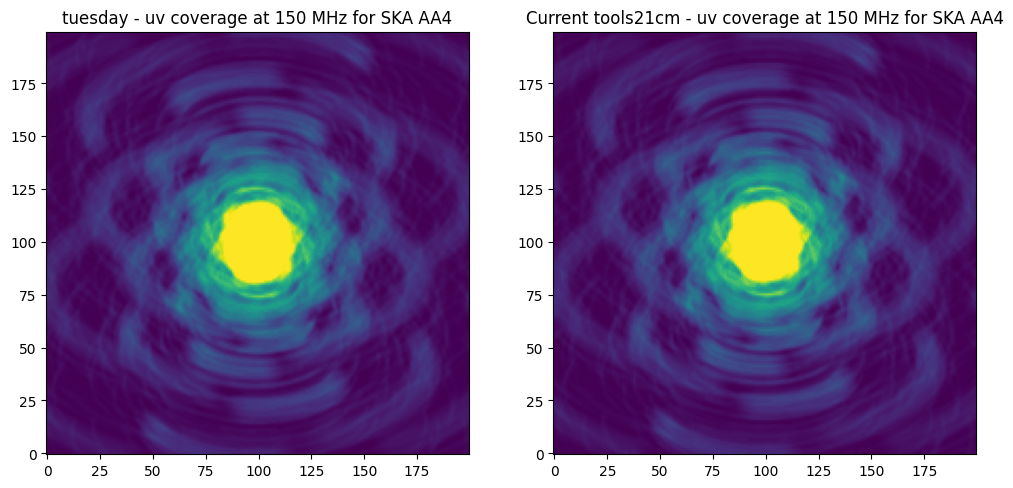

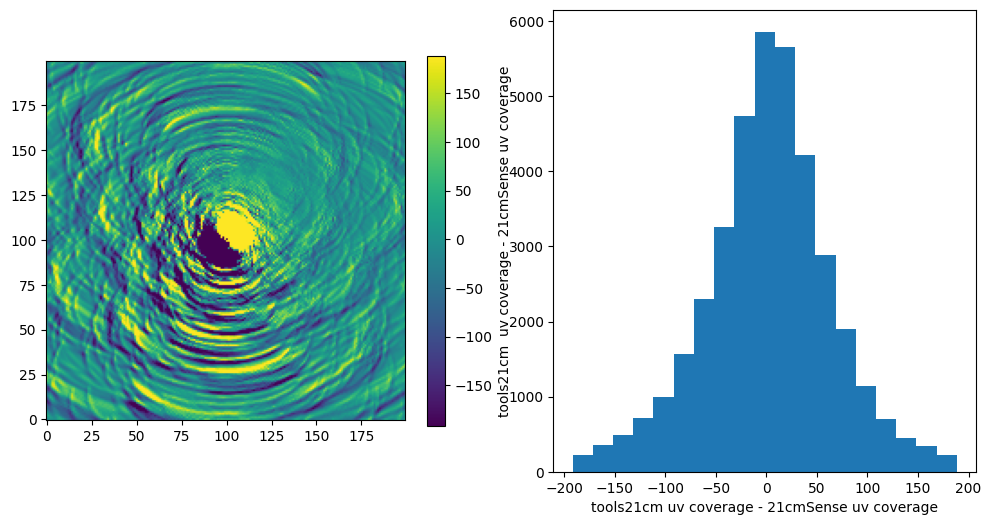

In [47]:
compare(uv_tools[...,0], uv_coverage[...,0], "uv coverage")

# Compare Tsys

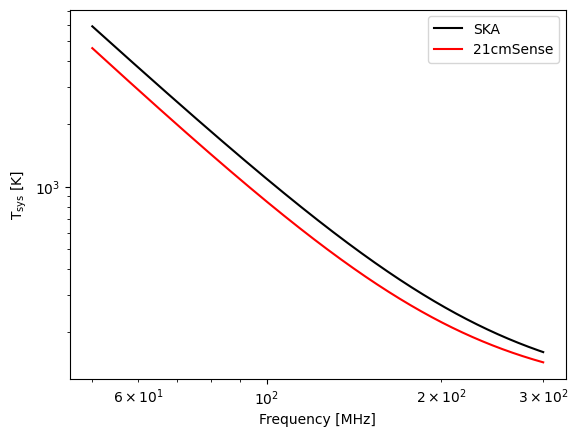

In [16]:
f = np.linspace(50,300,1000)
a = 60*(f/300)**(-2.55) + 100. # Tsys ~ Tsky; new tools21cm actually adds Trcv of 100K as well.
b = 260*(f/150)**(-2.6) + 100. # 21cmSense method: Tsys = Tsky + Trcv
plt.plot(f, a, color = "k", label = "SKA")
plt.plot(f, b, color = "r", label = "21cmSense")
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"T$_{\rm sys}$ [K]")
plt.loglog()
plt.legend()
plt.show()

# Calculate σ_uv with `tuesday`

In [17]:
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import c
def sigma_uv(observation, freqs, boxlen):
    r"""
    Calculate thermal noise RMS per integration
    
    Eqn 3 from Prelogovic+22 2107.00018 without the last sqrt term
    that comes from flux density [Jy] to temperature [mK] conversion of Eqn 9 in Ghara+16 1511.07448 
    but without the assumption of a circular symmetry of antenna distribution.
    
    observation: py21cmsense.Observation
    freqs: \nu in MHz
    """
    sig_uv = np.zeros(len(freqs))
    for i, nu in enumerate(freqs):
        obs = observation.clone(observatory=observation.observatory.clone(beam=observation.observatory.beam.clone(frequency=nu)))
        Tsys = 451000.*un.mK#obs.Tsys.to(un.mK)
        # =\lambda^2/A_{eff}, this approx assumes A_{eff} ~ 1000 m^2
        # In general, we could have a better estimate of A_{eff} that varies w freq
        # If we want the code to be generic and use \lambda^2/A_eff, 
        # we need to add maybe observatory.area_eff or observatory.omega_beam
#         f0 = 150. *un.MHz
        nu_crit = 110. * un.MHz
        ep = np.where(freqs > nu_crit, (nu_crit / freqs) ** 2, 1.0)[i].value
        A_eff = ep * np.pi*(observation.observatory.beam.dish_size/2.)**2
        wavelength = (c/nu.to("Hz")).to(un.m)
        omega_beam = (wavelength**2/A_eff) * un.rad**2 #0.004*(nu/f0)**(-2.) 
        d = cosmo.comoving_transverse_distance(f2z(nu)) # Mpc
        theta_box = (boxlen / d) * un.rad
        omega_pix = theta_box**2 / (200**2) #ncells**2
        sqrt = np.sqrt(2.*observation.bandwidth.to("Hz")*obs.integration_time).to(un.dimensionless_unscaled)
        # I have the exact same Tsys, same omega_pix, same A_eff, and same sqrt as tools
        sig_uv[i] = Tsys.value * omega_beam/omega_pix / sqrt/1e6 # I need this 1e6 to get the same numbers as tools...
    return sig_uv*Tsys.unit

In [18]:
# Define an observation
obs = Observation(observatory=observatory,
            time_per_day=hours_tracking,
            lst_bin_size=hours_tracking,
            integration_time=integration_time,
            bandwidth=50 *un.kHz,
            n_days=int(np.ceil(1000/hours_tracking.value)),
                 )

In [19]:
from astropy.constants import k_B
foo = (2*k_B*451*un.K/(517*un.m**2)).to(un.uJy)/np.sqrt(2.*obs.bandwidth.to("Hz")*integration_time)

In [20]:
foo.to(un.uJy)

<Quantity 983385.16396623 uJy>

In [21]:
from tools21cm.radio_telescope_sensitivity import sigma_noise_radio, jansky_2_kelvin, kelvin_2_jansky

jansky_2_kelvin(foo.to(un.Jy).value, f2z(freqs[0]), boxsize=boxlength.value, ncells=200)*un.mK

OMP 2.5340913055407976e-08 OMB 4.4469847245063775e-14


<Quantity 56.16880163 mK>

In [22]:
sigmaN = sigma_uv(obs, freqs*un.MHz, boxlength) #mK
sigmaN = sigmaN / np.sqrt(uv_coverage * obs.n_days)
sigmaN[uv_coverage == 0.] = 0.

# Calculate σ_uv with tools

In [23]:
from tools21cm.radio_telescope_sensitivity import sigma_noise_radio, jansky_2_kelvin, kelvin_2_jansky
from tools21cm.radio_telescope_noise import noise_map

In [24]:
sigma, rms_noi = sigma_noise_radio(f2z(freqs[0]), 
                                   obs.bandwidth.to(un.MHz).value, 
                                   obs.n_days*obs.time_per_day.value, 
                                   integration_time.value, 
                                   uv_map=uv_tools, 
                                   N_ant=512) #μJy
print("RMS",jansky_2_kelvin(rms_noi*1e-6, f2z(freqs[0]), boxsize=boxlength.value, ncells=lc_shape[0]))
sigmaN_tools = jansky_2_kelvin(rms_noi*1e-6, f2z(freqs[0]), boxsize=boxlength.value, ncells=lc_shape[0]) #mK
sigmaN_tools = sigmaN_tools / np.sqrt(uv_tools*obs.n_days)
sigmaN_tools[uv_tools == 0.] = 0.

AEFF [517.69858509]
SQRT 2449.489742783178

Expected: rms in image in µJy per beam for full = [11.08944821]
Effective baseline = [0.77240722] m
Calculated: rms in the visibility = [983444.49945772] µJy
OMP 2.5340913055407976e-08 OMB 4.4469847245063775e-14
RMS [56.17219074]
OMP 2.5340913055407976e-08 OMB 4.4469847245063775e-14


In [25]:
sigmaN_tools.max(), sigmaN.max()

(6.147211054518084, <Quantity 5.93400034 mK>)

# Compare σ_uv

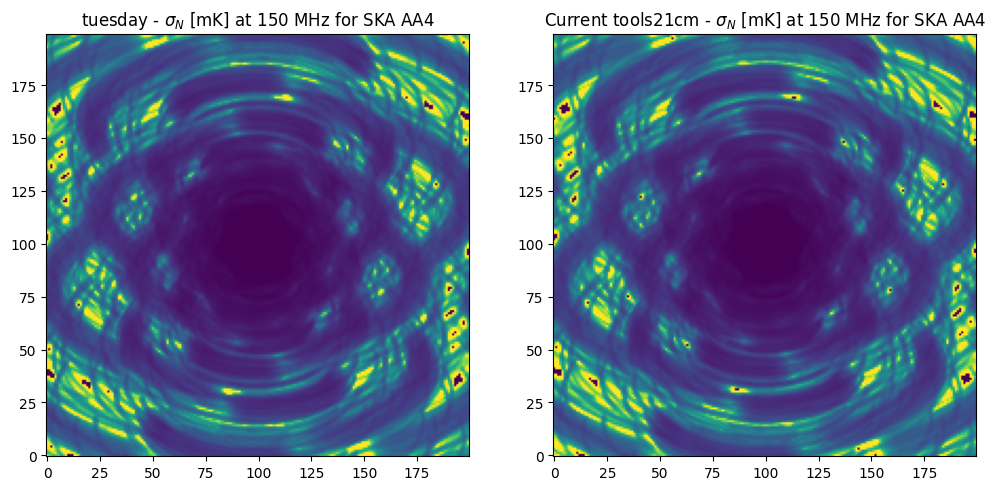

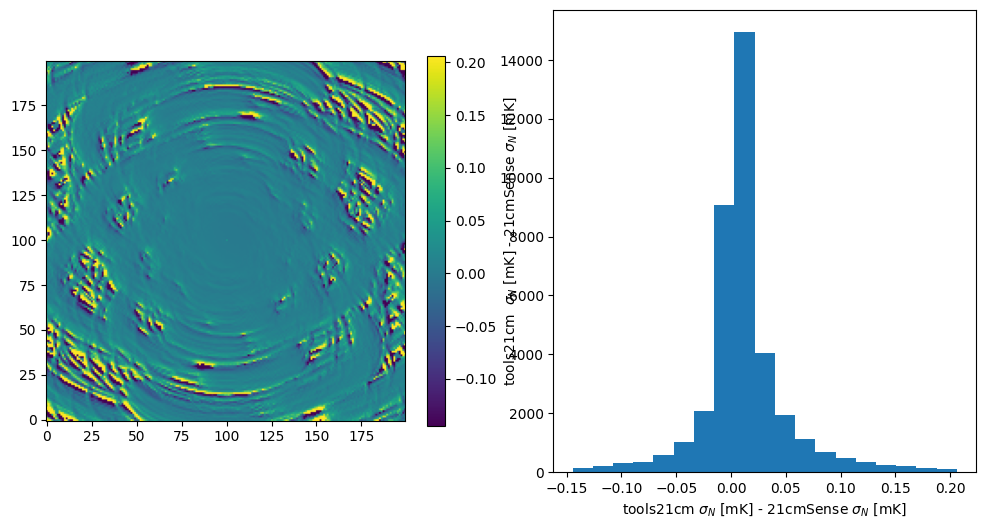

In [26]:
compare(sigmaN_tools[...,0], sigmaN[...,0].value, r"$\sigma_{N}$ [mK]")

# Sample lightcone noise `tools21cm`

In [27]:
from tools21cm.radio_telescope_noise import noise_map

In [28]:
noise_tools = noise_map(lc_shape[0], 
                        f2z(freqs[0]), 
                        obs.bandwidth.to(un.MHz).value, 
                        obs_time=obs.n_days*obs.time_per_day.value, 
                        subarray_type="AA4", 
                        boxsize=boxlength.value, 
                        total_int_time=obs.time_per_day.value, 
                        int_time=integration_time.value, 
                        declination=-26.824722,)*un.uJy
noise_tools = jansky_2_kelvin(noise_tools.to(un.Jy).value, f2z(freqs[0]), boxsize=boxlength.value, ncells=lc_shape[0])*un.mK

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:04<00:00, 73.73it/s]

...done
AEFF [517.69858509]
SQRT 2449.489742783178
RMS 983444.499457722 983444.499457722 983444.499457722 (1,)
NF (200, 200) (-3211646.740635436+1724689.5092600621j) (-89.61511660250808+725.9034605009305j) (1907067.9477554127+897523.4860941868j)
11.831144172860437
OMP 2.5340913055407976e-08 OMB 4.4469847245063775e-14


In [29]:
noise_tools.min(), noise_tools.mean(), noise_tools.max()

(<Quantity -0.00067856 mK>,
 <Quantity 1.64290328e-06 mK>,
 <Quantity 0.00070141 mK>)

In [35]:
from scipy.signal import windows

def sample_lc_noise(rms_noise, boxlength, observation, nsamples=1,mask=None):
    # given thermal noise map in uv space of shape (HII_DIM, HII_DIM,Nfreqs,),
    # return nsamples noise realisations on the lc
    lc_noise = np.zeros((nsamples,) + rms_noise.shape)
    for i in range(nsamples):
        noise = (
            np.random.normal(size=rms_noise.shape) + 1j * np.random.normal(size=rms_noise.shape)
        ) * rms_noise.value
        
        window_fnc = windows.blackmanharris(rms_noise.shape[0])
        window_fnc = (window_fnc[:,None] @ window_fnc[None,:])
        noise *= window_fnc[...,None]
        noise = (noise+np.conj(noise))/2.
        print(noise.shape, np.min(noise), np.mean(noise), np.max(noise))
        if mask is not None:
            # remove wedge
            noise = mask(noise)
        
        lc_noise[i] = np.fft.ifft2(np.fft.ifftshift(noise), axes = (0,1)).real #* np.sqrt(np.prod(rms_noise.shape[:2]))
    return lc_noise  # (nsamples, Nx, Ny, Nfreqs)

In [31]:
sigmaN_tools.shape

(200, 200, 1)

In [32]:
noise = sample_lc_noise(sigmaN_tools*un.mK, boxlength, obs)

(200, 200, 1) (-0.5647923848206438+0.3276938518122549j) (-0.0001343903767847029+1.7789646209912365e-05j) (0.35800388085857+0.09802786370264445j)


In [33]:
noise.shape, noise.max(), noise.mean(), noise.min()

((1, 200, 200, 1),
 0.0006113480752859974,
 -2.0711851269493793e-06,
 -0.0005843655649813191)

# Compare noise realisations

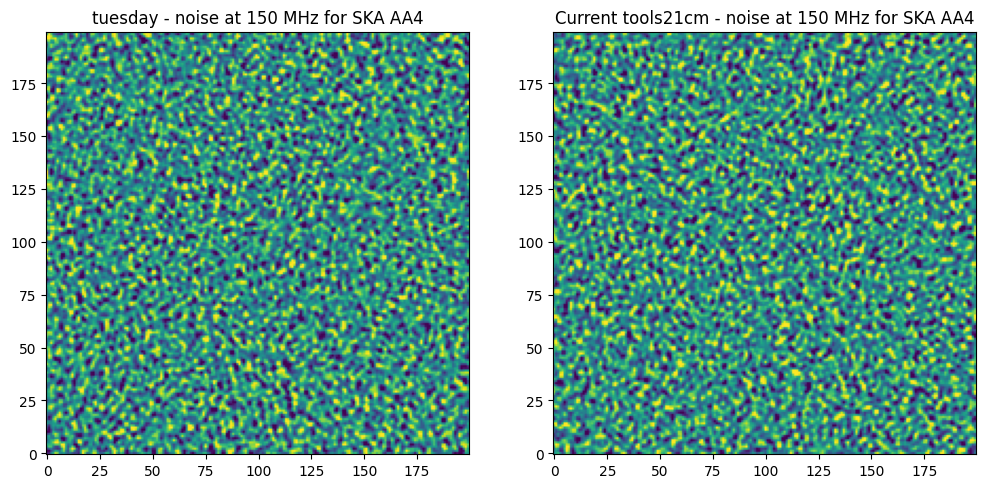

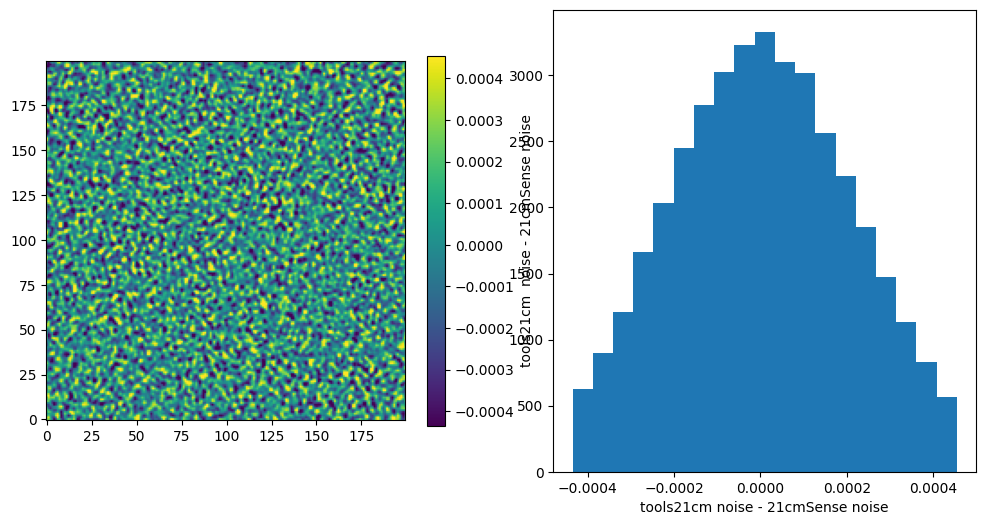

In [36]:
compare(noise_tools.value, noise[0,...,0], "noise")#, vmin=-1e-3, vmax=1e-3)